In [1]:
"""08. Finetune a pretrained detection model
============================================

Fine-tuning is commonly used approach to transfer previously trained model to a new dataset.
It is especially useful if the targeting new dataset is relatively small.

Finetuning from pre-trained models can help reduce the risk of overfitting.
Finetuned model may also generalizes better if the previously used dataset is in the similar domain of the new dataset.

This tutorial opens up a good approach for fine-tuning object detection models
provided by GluonCV.
More Specifically, we show how to use a customized Pikachu dataset and illustrate the finetuning fundamentals step by step.
You will be familiarize the steps and modify it to fit your own object detection projects.

"""
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz

#############################################################################################
# Pikachu Dataset
# ----------------
# First we will start with a nice Pikachu dataset generated by rendering 3D models on random real-world scenes.
# You can refer to :ref:`sphx_glr_build_examples_datasets_detection_custom.py` for tutorial of how to create your own datasets.
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

#############################################################################################
# We can load dataset using ``RecordFileDetection``
dataset = gcv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[0]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()


#############################################################################################
# Pre-trained models
# -------------------
# Now we can grab a pre-trained model to finetune from. Here we have so many choices from :ref:`gluoncv-model-zoo-detection` Model Zoo.
# Again for demo purpose, we choose a fast SSD network with MobileNet1.0 backbone.
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)

#############################################################################################
# reset network to predict pikachus!
net.reset_class(classes)
# now the output layers that used to map to VOC classes are now reset to distinguish pikachu (and background).

#############################################################################################
# There is a convenient API for creating custom network with pre-trained weights.
# This is equivalent to loading pre-trained model and call ``net.reset_class``.
#
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')

#############################################################################################
# By loading from fully pre-trained models, you are not only loading base network weights
# (mobilenet for example), but also some additional blocks for object detection specifically.
#
# Pretrained model from detection task is more relevant and adaptive than ``pretrained_base``
# network which is usually trained on ImageNet for image classification task.
#
# Therefore finetuning may converge significantly faster and better in some situations.

#############################################################################################
# Finetuning is a new round of training
# --------------------------------------
# .. hint::
#
#     You will find a more detailed training implementation of SSD here:
#     :download:`Download train_ssd.py<../../../scripts/detection/ssd/train_ssd.py>`
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 4, 4)

#############################################################################################
# Try use GPU for training
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
    print('using GPU ;)')
except:
    ctx = [mx.cpu()]
    print('using CPU :(')

#############################################################################################
# Start training(finetuning)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

for epoch in range(0, 2):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

#############################################################################################
# Save finetuned weights to disk
net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')

#############################################################################################
# Predict with finetuned model
# ----------------------------
# We can test the performance using finetuned weights
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gcv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

#############################################################################################
# In two epochs and less than 5 min, we are able to detect pikachus perfectly!
#
# .. hint::
#
#     This finetune tutorial is not limited to SSD, you can extend it to Faster-RCNN, YOLO training by
#     adapting a training blocks in the following examples:
#
#     :download:`Download train_faster_rcnn.py<../../../scripts/detection/faster_rcnn/train_faster_rcnn.py>`
#     :download:`Download train_yolo3.py<../../../scripts/detection/yolo/train_yolo3.py>`


label: [[309.6292  205.79944 355.75494 274.14044   0.     ]]


<Figure size 640x480 with 1 Axes>

/home/test/anaconda3/envs/tensorflow_gpuenv/lib/python3.7/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


using GPU ;)
[Epoch 0][Batch 0], Speed: 0.179 samples/sec, CrossEntropy=15.885, SmoothL1=1.689
[Epoch 0][Batch 20], Speed: 21.034 samples/sec, CrossEntropy=4.698, SmoothL1=1.417
[Epoch 0][Batch 40], Speed: 18.291 samples/sec, CrossEntropy=3.665, SmoothL1=1.236
[Epoch 0][Batch 60], Speed: 20.890 samples/sec, CrossEntropy=3.149, SmoothL1=1.102
[Epoch 0][Batch 80], Speed: 19.900 samples/sec, CrossEntropy=2.830, SmoothL1=1.025
[Epoch 0][Batch 100], Speed: 16.516 samples/sec, CrossEntropy=2.620, SmoothL1=0.966
[Epoch 0][Batch 120], Speed: 18.188 samples/sec, CrossEntropy=2.471, SmoothL1=0.914
[Epoch 0][Batch 140], Speed: 17.844 samples/sec, CrossEntropy=2.344, SmoothL1=0.890
[Epoch 0][Batch 160], Speed: 19.625 samples/sec, CrossEntropy=2.256, SmoothL1=0.858
[Epoch 0][Batch 180], Speed: 17.185 samples/sec, CrossEntropy=2.214, SmoothL1=0.845
[Epoch 0][Batch 200], Speed: 21.549 samples/sec, CrossEntropy=2.149, SmoothL1=0.833
[Epoch 0][Batch 220], Speed: 22.708 samples/sec, CrossEntropy=2.084, 

89KB [00:00, 3289.39KB/s]             


<Figure size 640x480 with 1 Axes>

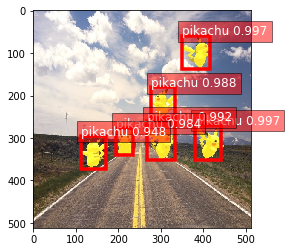

In [2]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gcv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()